In [7]:
%run "utilspro.py"


In [4]:
# Unzipping the provided dataset
with zipfile.ZipFile("incident+management+process+enriched+event+log.zip", 'r') as z:
    # Listing files in the zip archive
    file_names = z.namelist()
    # Loading the dataset (assuming the first file in the archive is the desired dataset)
    dataset_path = z.extract(file_names[0])


# Loading the dataset
data = pd.read_csv(dataset_path)

# Displaying the first few rows of the dataset
data.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


## Data structure and summary

In [5]:
# Checking the data structure (data types and missing values)
data_info = data.info()

# Checking for placeholder values (assuming '?' is a placeholder)
placeholder_counts = data.apply(lambda x: x[x == '?'].count())

# Getting statistical summary of the dataset for numerical columns
data_summary = data.describe()

data_info, placeholder_counts, data_summary


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   141712 non-null  object
 1   incident_state           141712 non-null  object
 2   active                   141712 non-null  bool  
 3   reassignment_count       141712 non-null  int64 
 4   reopen_count             141712 non-null  int64 
 5   sys_mod_count            141712 non-null  int64 
 6   made_sla                 141712 non-null  bool  
 7   caller_id                141712 non-null  object
 8   opened_by                141712 non-null  object
 9   opened_at                141712 non-null  object
 10  sys_created_by           141712 non-null  object
 11  sys_created_at           141712 non-null  object
 12  sys_updated_by           141712 non-null  object
 13  sys_updated_at           141712 non-null  object
 14  contact_type        

(None,
 number                          0
 incident_state                  0
 active                          0
 reassignment_count              0
 reopen_count                    0
 sys_mod_count                   0
 made_sla                        0
 caller_id                      29
 opened_by                    4835
 opened_at                       0
 sys_created_by              53076
 sys_created_at              53076
 sys_updated_by                  0
 sys_updated_at                  0
 contact_type                    0
 location                       76
 category                       78
 subcategory                   111
 u_symptom                   32964
 cmdb_ci                    141267
 impact                          0
 urgency                         0
 priority                        0
 assignment_group            14213
 assigned_to                 27496
 knowledge                       0
 u_priority_confirmation         0
 notify                          0
 problem_id  

* #### Data Columns and Types:
The dataset has 141,712 entries and 36 columns.
Data types include objects (strings), integers, and booleans.
Several columns like opened_at, resolved_at, and closed_at are of object type (strings) representing dates. We may need to convert these to datetime format for further analysis.

* #### Placeholder Values (?):
Several columns contain the placeholder value ?. For instance, the cmdb_ci column has 141,267 such values, which is a significant portion of the total entries.
Other columns with a high count of placeholders include sys_created_by, u_symptom, problem_id, rfc, vendor, and caused_by.

* ### Statistical Summary:
reassignment_count ranges from 0 to 27, with an average of around 1.1.
reopen_count has a maximum value of 8, but 75% of the data is still 0, indicating that most incidents are not reopened.
sys_mod_count (probably indicating system modifications) has a wide range, with values from 0 to 129 and an average of around 5.

#### Granularity and uniqueness


In [6]:
# Checking the uniqueness of the 'number' column
unique_incidents = data['number'].nunique()
total_entries = len(data)

unique_incidents, total_entries

(24918, 141712)

* 24,918 unique incidents (as indicated by the number column).
* 141,712 total entries.

This suggests that the dataset is not at the granularity of individual incidents. Instead, each incident has multiple entries, possibly capturing different states or updates related to the incident over time.

### Data distribution

We'll focus on the following columns:

 * Numerical: reassignment_count, reopen_count, and sys_mod_count.
* Categorical: incident_state, contact_type, and priority.

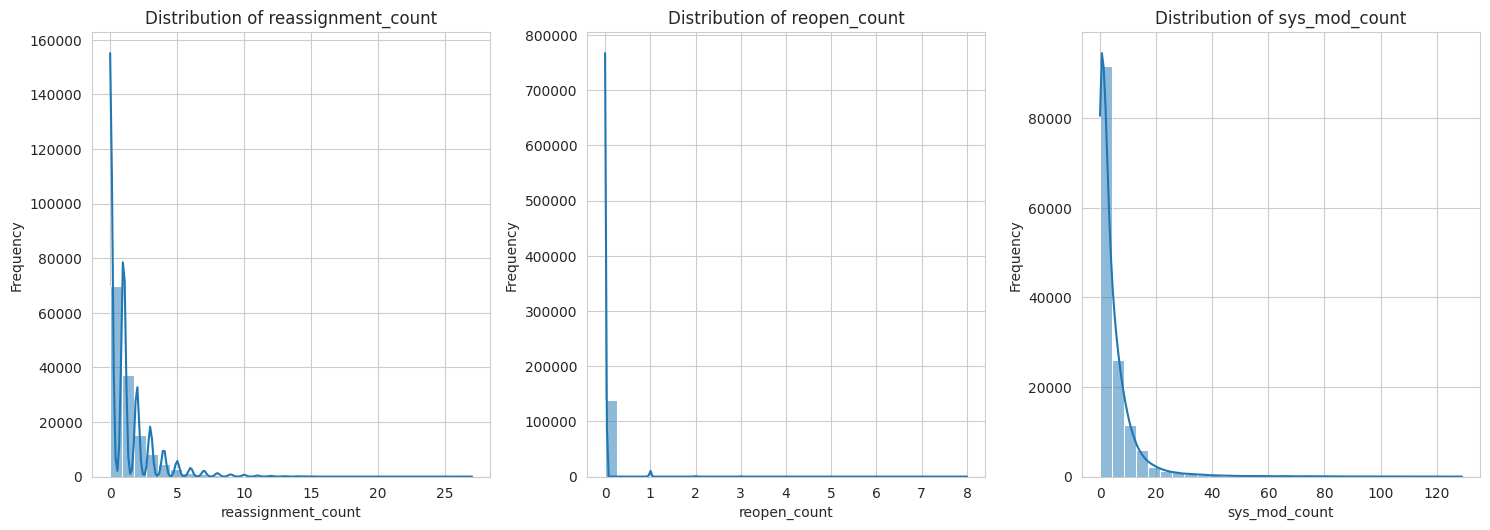

In [8]:
# Setting up the plotting environment
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))

# Plotting the distribution of the numerical columns
numerical_columns = ['reassignment_count', 'reopen_count', 'sys_mod_count']

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

* ### Reassignment Count:
 Most incidents are reassigned once or not at all, with a sharp decline in frequency as the number of reassignments increases.
* ### Reopen Count:
The vast majority of incidents are not reopened. Only a small number of incidents have been reopened multiple times.
* ### Sys Mod Count (System Modification Count):
 Most incidents have a system modification count between 0 and 10. However, there's a long tail, indicating that some incidents have been modified many time

 let's visualize the distribution of the selected categorical columns: incident_state, contact_type, and priority.

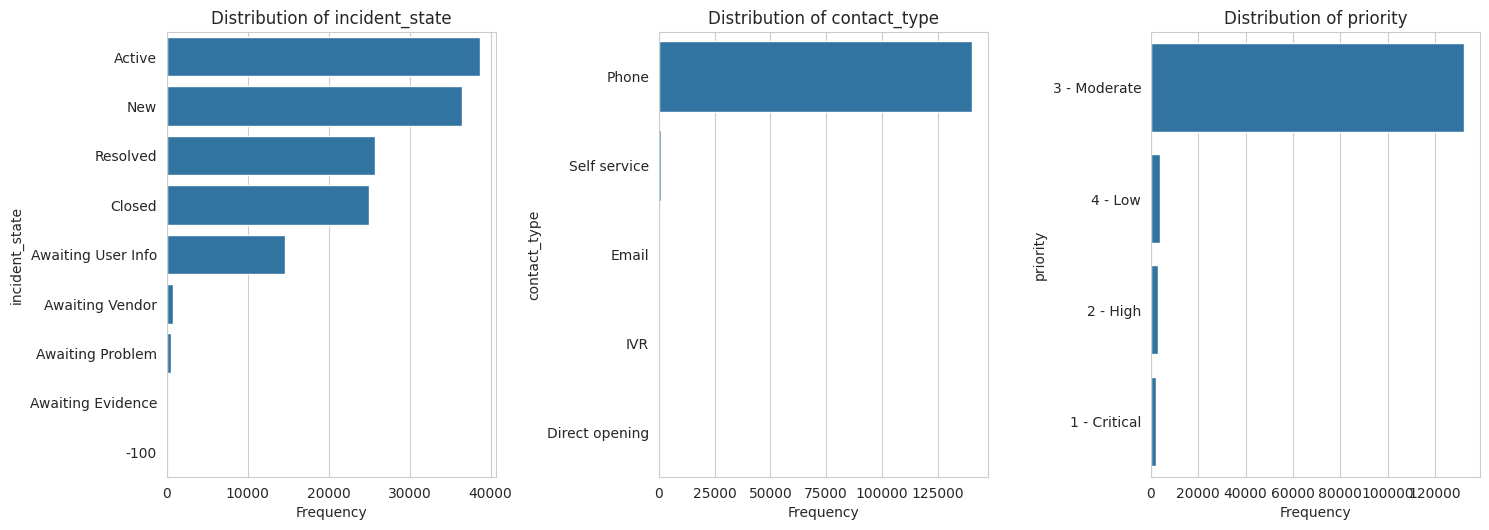

In [9]:
# Plotting the distribution of the categorical columns
categorical_columns = ['incident_state', 'contact_type', 'priority']

plt.figure(figsize=(15, 10))

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=data, y=column, order=data[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xlabel('Frequency')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

* ### Incident State:
The most common state is "Active", followed by "New" and "Resolved".
States like "Awaiting Problem", "Awaiting Vendor", and "Awaiting Evidence" have considerably fewer occurrences.
* ### Contact Type:
The vast majority of incidents are reported via "Phone", with very few incidents reported through "Email", "Self service", or "Direct opening".
* ### Priority:
The "3 - Moderate" priority level is the most common, followed by "2 - High" and "4 - Low". There are fewer incidents with "1 - Critical" and "5 - Very Low" priorities.

### Correlation analysis

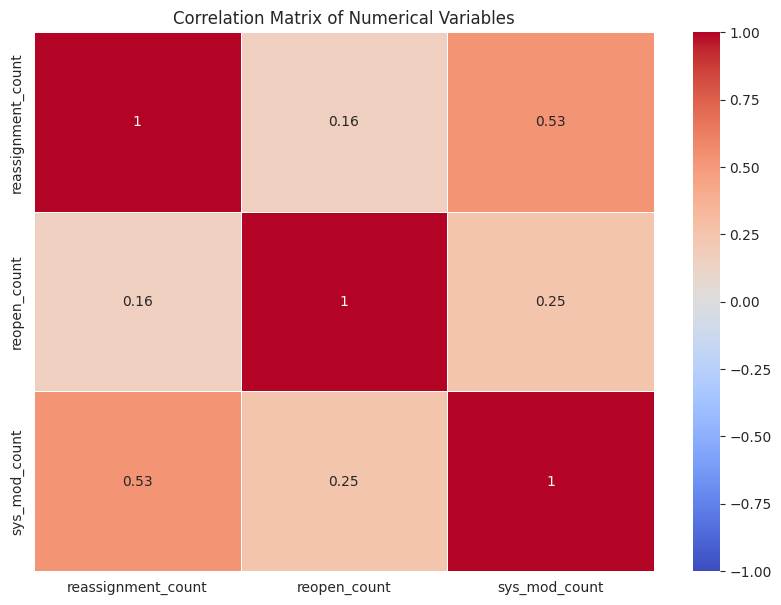

In [10]:
# Correlation matrix for numerical columns
correlation_matrix = data[numerical_columns].corr()

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

* ### Reassignment Count and Sys Mod Count: 
There's a light positive correlation (approximately 0.53) between these two variables. This indicates that as incidents are reassigned more often, the number of system modifications also tends to increase.
* ### Reopen Count:
This variable doesn't have a strong correlation with the other two. Its correlation with both reassignment_count and sys_mod_count is relatively low.

### Anomaly Detection

We'll focus on identifying potential outliers within the numerical columns. Outliers can distort the results of our analyses and models.

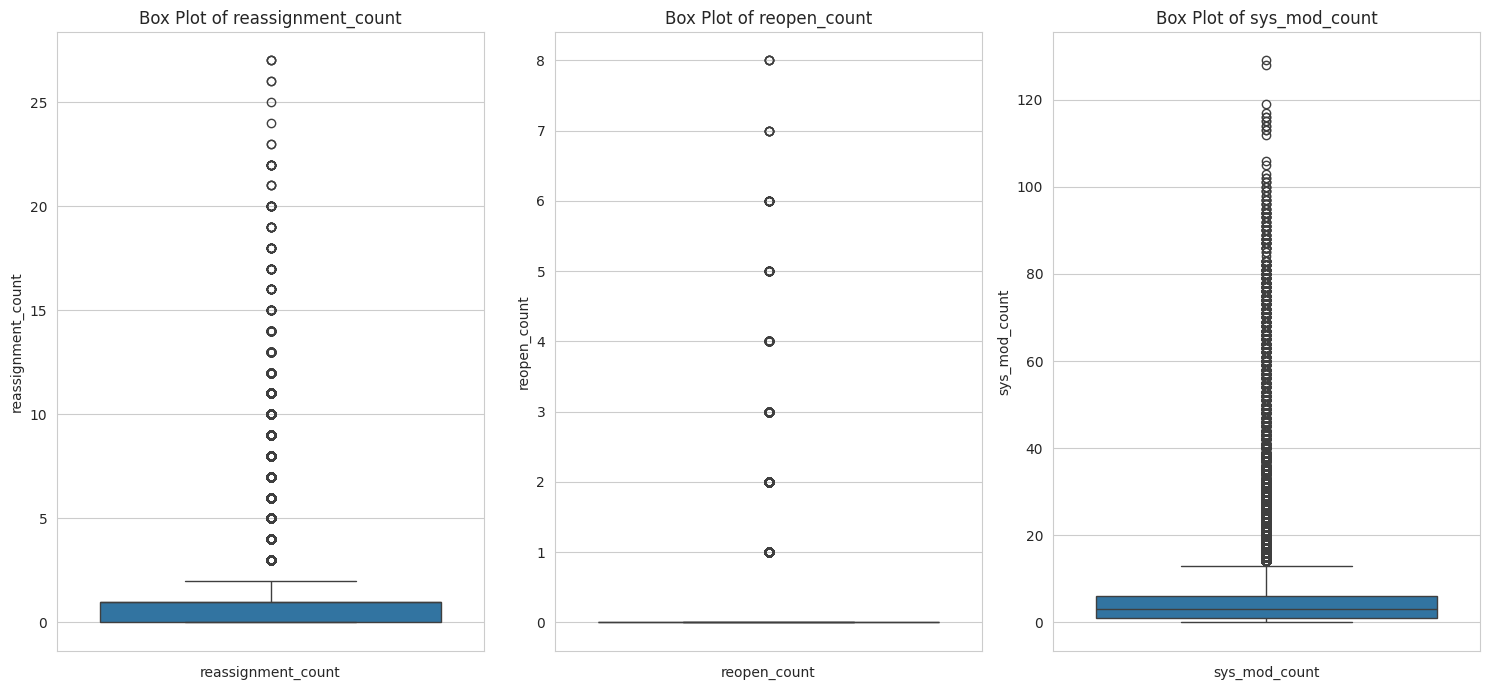

In [11]:
# Plotting boxplots for anomaly detection in numerical columns
plt.figure(figsize=(15, 7))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()